# Optimized Healthcare Simulation with Q-Learning
This notebook simulates a constrained healthcare system with patient flow across disease pathways, clinical interventions, and system-level optimization using Q-learning.

In [57]:
# Step 1: Imports and Initial Setup
import numpy as np
import pandas as pd
import random

# Data manipulation and analysis
import itertools
from collections import defaultdict
import networkx as nx
import heapq

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go #Sankey diagram

# Set random seed for reproducibility if required
#np.random.seed(0)
#random.seed(0)

# Define Classes

In [58]:
# Step 2: Define Patient Class with Time-Dependent Variables
class Patient:
    """
    Represents a patient in the healthcare simulation.

    Attributes:
        pid (int): Unique identifier for the patient.
        age (int): Age of the patient.
        sex (str): Gender of the patient ('M' or 'F').
        diseases (dict): Dictionary indicating the presence of diseases across pathways.
        clinical (dict): Clinical variables and their current values.
        priority (str): Priority level of the patient ('High', 'Medium', 'Low').
        outcomes (dict): Metrics for queue and clinical penalties.
        history (list): List of actions the patient has undergone.
        queue_time (int): Total time the patient has spent in queues.
    """
    
    def __init__(self, pid):
        """
        Initializes a new Patient instance.
        """
        
        self.pid = pid
        self.age = np.random.randint(40, 90)
        self.sex = np.random.choice(['M', 'F'])
        self.diseases = {f'P{p}': False for p in range(NUM_PATHWAYS)}
        self.clinical = {k: np.random.normal(v, 5) for k, v in IDEAL_CLINICAL_VALUES.items()}
        self.priority = random.choice(["High", "Medium", "Low"]) 
        self.outcomes = {'queue_penalty': 13000000, 'clinical_penalty': 100}
        self.history = []
        self.queue_time = 0
            
    # --- Patient disease progression & clinical decay ---
    @staticmethod
    def progress_diseases(patient, t):
        for p in patient.diseases:
            if not patient.diseases[p] and np.random.rand() < 0.05:
                patient.diseases[p] = True
        for k in patient.clinical:
            patient.clinical[k] += np.random.normal(0.5, 0.1)
        

    # --- Patient actions and outcomes ---
    def apply_action(self, effect):
        """
        Applies the effects of an action to the patient's clinical variables.
        
        Args:
            effect (dict): Dictionary of clinical variable changes.
        """
        for k, v in effect.items():
            if k in self.clinical:
                if self.clinical[k] < IDEAL_CLINICAL_VALUES[k]:
                    self.clinical[k] = self.clinical[k] + v
                else:
                    self.clinical[k] = self.clinical[k] - v

    # --- Patient scoring and outcome calculation ---
    def score_outcomes(self):
        """
        Updates the patient's outcome metrics based on their current state. 
        The queue penalty is reduced based on the time spent in the queue, and the clinical penalty is calculated based on the clinical variables vs user set ideal clinical variables.
        """
        
        self.outcomes['queue_penalty'] = max(0, self.outcomes['queue_penalty'] - self.queue_time * 0.005)
        self.outcomes['clinical_penalty'] = sum(
        abs(self.clinical[k] - IDEAL_CLINICAL_VALUES[k]) for k in self.clinical if k in IDEAL_CLINICAL_VALUES)
    

In [59]:
# Step 3: Define Actions
class Action:
    """
    Represents an action or intervention in the healthcare simulation.

    Attributes:
        name (str): The name of the action.
        capacity (int): The maximum number of patients the action can handle at a time.
        effect (dict): A dictionary specifying the effect of the action on clinical variables.
        cost (int): The cost associated with performing the action.
        duration (int): The duration of the action in time steps.
        queue (list): A priority queue of patients waiting for the action.
        schedule (list): A record of the number of patients served at each time step.
    """
    
    def __init__(self, name, capacity, effect, cost, duration):
        self.name = name
        self.capacity = capacity
        self.effect = effect
        self.cost = cost
        self.duration = duration
        self.queue = []  # Use a priority queue
        self.schedule = []

    def assign(self, patient):
        """
        Assigns a patient to the action's queue based on their priority.
        """
        # Determine previous action from patient history
        prev_action = patient.history[-1] if patient.history else None
        # We don't know next action at assignment, so set to None for now
        activity_log.append({
            "action_name": self.name,
            "patient_id": patient.pid,
            "simulation_time": step if 'step' in globals() else None,
            "previous_action": prev_action,
            "next_action": None  # Will be updated after next assignment if needed
        })
        priority_map = {"High": 1, "Medium": 2, "Low": 3}
        # Combine priority level and outcomes score for sorting
        priority_score = priority_map[patient.priority] + patient.outcomes['queue_penalty']
        heapq.heappush(self.queue, (priority_score, patient.pid, patient))

    def execute(self):
        in_progress = []
        while self.queue and len(in_progress) < self.capacity:
            _, _, patient = heapq.heappop(self.queue)  # Pop the highest-priority patient
            patient.queue_time += 1
            patient.apply_action(self.effect)
            patient.score_outcomes()
            in_progress.append(patient)
        self.schedule.append(len(in_progress))

        # After execution, update next_action for each patient if possible
        for patient in in_progress:
            # Find the last log entry for this patient and action
            for entry in reversed(activity_log):
                if entry["patient_id"] == patient.pid and entry["action_name"] == self.name and entry["next_action"] is None:
                    # Next action is the last in patient.history if it exists and is not this action
                    if len(patient.history) > 1:
                        next_action = patient.history[-1]
                        if next_action != self.name:
                            entry["next_action"] = next_action
                    break
        return in_progress, len(in_progress) * self.cost
    
    

In [60]:
# Step 4: Define Pathways
class Pathway:
    """
    Represents a healthcare pathway with transitions and thresholds.

    Attributes:
        name (str): The name of the pathway.
        transitions (dict): A dictionary defining possible transitions between actions.
        thresholds (dict): A dictionary defining thresholds for transitions based on clinical variables.
    """
    
    def __init__(self, name, transitions, thresholds):
        self.name = name
        self.transitions = transitions
        self.thresholds = thresholds
    
    def next_action(self, patient, q_threshold):
        """
        Determines the next action for a patient based on their clinical variables, thresholds,
        and additional criteria such as age and a random factor.
        When q_threshold is negative, actions with lower cost are favored.
        When q_threshold is positive, actions with larger sum of effects are favored.
        Returns:
            str or None: The name of the next action if a transition condition is met, otherwise None.
        """
        for p_code in patient.diseases:
            if p_code not in self.transitions:
                continue
            if not patient.diseases[p_code]:
                continue

            valid_actions = []
            for action, thresholds in self.transitions[p_code].items():
                # Check clinical variables
                clinical_check = all(
                    k in patient.clinical and patient.clinical[k] < thresholds[k]
                    for k in IDEAL_CLINICAL_VALUES.keys()
                )
                valid_actions.append(action)

            if valid_actions:
                    abs_q = max(1, abs(q_threshold))  # Ensure at least 1 for scaling
                    if q_threshold < 0:
                        # Weight towards actions with lower cost, scaled by |q_threshold|
                        costs = np.array([actions[a].cost for a in valid_actions])
                        weights = 1 / (costs + 1e-6)
                        weights = weights ** abs_q
                        weights = weights / weights.sum()
                        chosen_action = np.random.choice(valid_actions, p=weights)
                    elif q_threshold > 0:
                        # Weight towards actions with larger sum of effects, scaled by |q_threshold|
                        effects = np.array([sum(abs(v) for v in actions[a].effect.values()) for a in valid_actions])
                        if effects.sum() == 0:
                            weights = np.ones(len(valid_actions)) / len(valid_actions)
                        else:
                            weights = effects ** abs_q
                            weights = weights / weights.sum()
                        chosen_action = np.random.choice(valid_actions, p=weights)
                    else:
                        # Uniform random choice
                        chosen_action = random.choice(valid_actions)    
                    return chosen_action

        return None
   

# Build the System

In [61]:
# Step 5: Simulate System
""" 
This step initializes the simulation by creating a list of patients and defining actions with their respective capacities, effects, costs, and durations.
It also sets up pathways with transition thresholds based on clinical variables.
The resulting `actions` dictionary contains 10 `Action` objects, each with unique configurations based on the value of `i`.
The thresholds dictionary defines the conditions under which patients can transition from one action to another, based on their clinical variables.
The pathways list contains 10 `Pathway` objects, each with its own set of transitions and thresholds.
"""

NUM_PATIENTS = 10
NUM_PATHWAYS = 10
NUM_ACTIONS = 10
NUM_STEPS = 30
CAPACITY = 12
AGE_THRESHOLD = 60

# --- Ideal clinical values ---
IDEAL_CLINICAL_VALUES = {
    'bp': 120,
    'glucose': 90,
    'bmi': 22,
    'oxygen': 98,
    'mental_health': 80,
}

# --- Initialize patients and actions ---
patients = [Patient(i) for i in range(NUM_PATIENTS)]
actions = {
    f'a{i}': Action(
        f'a{i}', 
        capacity=CAPACITY, 
        effect = {k: (np.random.normal(2,0.05) if j == i % 5 else 0) for j, k in enumerate(IDEAL_CLINICAL_VALUES.keys())},
        cost=np.random.randint(20, 100), 
        duration=np.random.randint(1, 3)        #removes_disease=random.rand() < 0.1
    )
    for i in range(10)
}

threshold_matrix = {
    f'P{p}': {
        f'a{i}': {
            **{k: np.random.normal(v, 5) for k, v in IDEAL_CLINICAL_VALUES.items()},
            'age': np.random.randint(18, 65),
            'rand_factor': np.random.uniform(0.2, 0.8)
        }
        for i in range(NUM_ACTIONS)
    }
    for p in range(NUM_PATHWAYS)
}

pathways = [Pathway(f'd{i}', threshold_matrix, threshold_matrix) for i in range(10)]


# Create a transition matrix
"""
This step creates a transition matrix that defines possible transitions between actions for each pathway.

1. For each pathway (P0 to P9), a dictionary is created where:
    - The keys are action names (e.g., 'a0', 'a1', ..., 'a9').
    - The values are lists of randomly selected next actions that the current action can transition to.
2. The number of next actions for each action is determined randomly, and the next actions are sampled from the list of all actions.
3. This transition matrix is used to model the flow of patients between actions within each pathway.

The resulting `transition_matrix` is a dictionary where each pathway contains a mapping of actions to their possible next actions.
"""

transition_matrix = {}
for p in range(NUM_PATHWAYS):
    transition_matrix[f'P{p}'] = {
        f'a{i}': random.sample(list(actions.keys()), random.randint(1, NUM_ACTIONS)) #random combinations
        for i in range(NUM_ACTIONS)
    }

# Visualise the System Created:
- Patients
- Action Effects
- Pathways (tabular and graphical)
- Thresholds for the pathways

In [62]:
# Display the first few patients
for i, patient in enumerate(patients[:3]):
    print(f"Patient {i+1}:")
    print(f"  ID: {patient.pid}")
    print(f"  Age: {patient.age}")
    print(f"  Sex: {patient.sex}")
    print(f"  Diseases: {patient.diseases}")
    print(f"  Clinical Variables: {patient.clinical}")
    print(f"  Outcomes: {patient.outcomes}")
    print(f"  Queue Time: {patient.queue_time}")
    print(f"  History: {patient.history}")
    print()

Patient 1:
  ID: 0
  Age: 72
  Sex: M
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4': False, 'P5': False, 'P6': False, 'P7': False, 'P8': False, 'P9': False}
  Clinical Variables: {'bp': 117.6181746166781, 'glucose': 89.48135010686346, 'bmi': 23.38433424443423, 'oxygen': 99.24300232131603, 'mental_health': 81.58444434266278}
  Outcomes: {'queue_penalty': 13000000, 'clinical_penalty': 100}
  Queue Time: 0
  History: []

Patient 2:
  ID: 1
  Age: 86
  Sex: M
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4': False, 'P5': False, 'P6': False, 'P7': False, 'P8': False, 'P9': False}
  Clinical Variables: {'bp': 116.7752401981107, 'glucose': 89.85700876200542, 'bmi': 25.51717419792865, 'oxygen': 94.58840673045796, 'mental_health': 84.22942156953535}
  Outcomes: {'queue_penalty': 13000000, 'clinical_penalty': 100}
  Queue Time: 0
  History: []

Patient 3:
  ID: 2
  Age: 88
  Sex: M
  Diseases: {'P0': False, 'P1': False, 'P2': False, 'P3': False, 'P4':

In [63]:
# Display the first two actions
for action_name, action_obj in list(actions.items())[:10]:
    print(f"Action Name: {action_name}")
    print(f"  Capacity: {action_obj.capacity}")
    print(f"  Effect: {action_obj.effect}")
    print(f"  Cost: {action_obj.cost}")
    print(f"  Duration: {action_obj.duration}")
    print()

Action Name: a0
  Capacity: 12
  Effect: {'bp': 2.0076930059834863, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 43
  Duration: 2

Action Name: a1
  Capacity: 12
  Effect: {'bp': 0, 'glucose': 2.1521843410367376, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 67
  Duration: 1

Action Name: a2
  Capacity: 12
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 1.9779916268173008, 'oxygen': 0, 'mental_health': 0}
  Cost: 84
  Duration: 1

Action Name: a3
  Capacity: 12
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 0, 'oxygen': 2.0611726998504465, 'mental_health': 0}
  Cost: 44
  Duration: 2

Action Name: a4
  Capacity: 12
  Effect: {'bp': 0, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 1.9928764787670468}
  Cost: 99
  Duration: 1

Action Name: a5
  Capacity: 12
  Effect: {'bp': 1.9604905686817267, 'glucose': 0, 'bmi': 0, 'oxygen': 0, 'mental_health': 0}
  Cost: 89
  Duration: 1

Action Name: a6
  Capacity: 12
  Effect: {'bp': 0, 'glucose': 1.9834163319735312, 'bmi': 0, 'o

In [64]:
# Display the transition matrix
for pathway, transitions in transition_matrix.items():
    print(f"Pathway: {pathway}")
    for action, next_actions in transitions.items():
        print(f"  Action: {action} -> Next Actions: {next_actions}")
    print()

Pathway: P0
  Action: a0 -> Next Actions: ['a7', 'a1', 'a3', 'a9', 'a8', 'a4', 'a2', 'a6', 'a0']
  Action: a1 -> Next Actions: ['a1', 'a6', 'a8', 'a9']
  Action: a2 -> Next Actions: ['a5', 'a3', 'a2', 'a7', 'a8', 'a9', 'a0', 'a4']
  Action: a3 -> Next Actions: ['a5', 'a9']
  Action: a4 -> Next Actions: ['a7', 'a4', 'a1']
  Action: a5 -> Next Actions: ['a9', 'a3', 'a5', 'a8']
  Action: a6 -> Next Actions: ['a2', 'a9', 'a4', 'a3']
  Action: a7 -> Next Actions: ['a3', 'a7', 'a4', 'a2', 'a6', 'a1', 'a0', 'a8', 'a5', 'a9']
  Action: a8 -> Next Actions: ['a8', 'a1', 'a7', 'a9', 'a2', 'a6', 'a0', 'a5']
  Action: a9 -> Next Actions: ['a5', 'a6', 'a1', 'a9', 'a7', 'a3', 'a4', 'a0']

Pathway: P1
  Action: a0 -> Next Actions: ['a9', 'a6']
  Action: a1 -> Next Actions: ['a2']
  Action: a2 -> Next Actions: ['a0', 'a6', 'a9']
  Action: a3 -> Next Actions: ['a9', 'a0']
  Action: a4 -> Next Actions: ['a7', 'a1', 'a3']
  Action: a5 -> Next Actions: ['a0', 'a1', 'a4', 'a6', 'a5']
  Action: a6 -> Next Ac

In [65]:
# Display the threshold matrix for the first two pathways
for pathway, actions_thresholds in list(threshold_matrix.items())[:2]:
    print(f"Pathway: {pathway}")
    for action, thresholds in actions_thresholds.items():
        print(f"  Action: {action}")
        print(f"    Thresholds: {thresholds}")
    print()

Pathway: P0
  Action: a0
    Thresholds: {'bp': 110.89222796076608, 'glucose': 92.37240458583351, 'bmi': 20.51389753214087, 'oxygen': 95.52993826237764, 'mental_health': 74.05624072162568, 'age': 29, 'rand_factor': 0.41866763545585894}
  Action: a1
    Thresholds: {'bp': 119.81638473545766, 'glucose': 86.83622389759446, 'bmi': 23.312252499514106, 'oxygen': 91.80815995260878, 'mental_health': 77.53978312373769, 'age': 58, 'rand_factor': 0.5836803829796754}
  Action: a2
    Thresholds: {'bp': 128.53713083802333, 'glucose': 100.30486741040923, 'bmi': 12.115672168577971, 'oxygen': 98.44202231681537, 'mental_health': 77.84819878249358, 'age': 53, 'rand_factor': 0.24493917455284625}
  Action: a3
    Thresholds: {'bp': 123.98703380527681, 'glucose': 89.78089566932134, 'bmi': 18.2804971150637, 'oxygen': 98.86006975290665, 'mental_health': 82.51375058761094, 'age': 49, 'rand_factor': 0.7789288977880329}
  Action: a4
    Thresholds: {'bp': 119.41310028998423, 'glucose': 85.23871492549675, 'bmi':

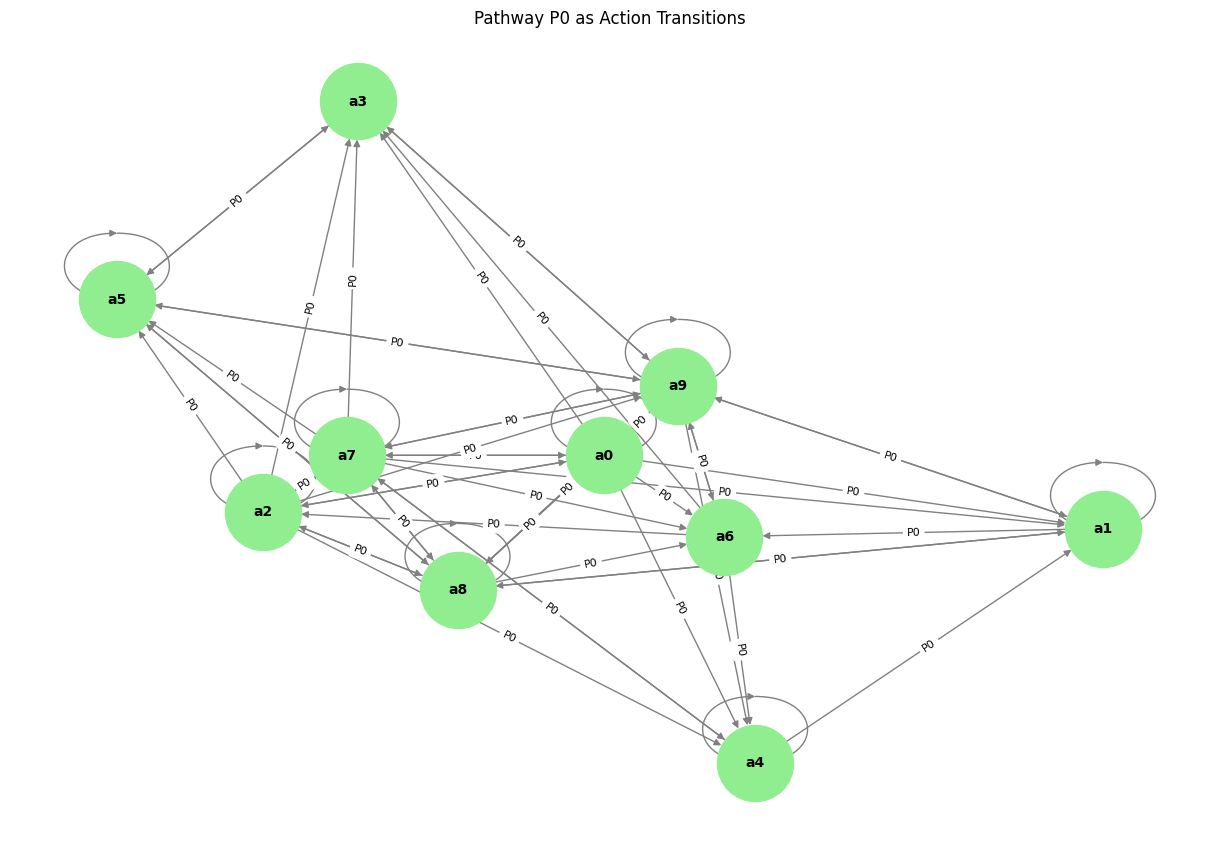

In [66]:
# Visualize a single pathway as a set of action transitions using a directed graph
plt.figure(figsize=(12, 8))
G_transitions_single = nx.DiGraph()

# Specify the pathway to visualize
selected_pathway = 'P0'  # Change this to the desired pathway

# Add nodes and edges for the selected pathway
if selected_pathway in transition_matrix:
    actions_transitions = transition_matrix[selected_pathway]
    for action, next_actions in actions_transitions.items():
        for next_action in next_actions:
            G_transitions_single.add_edge(action, next_action, label=selected_pathway)

# Draw the graph
pos = nx.spring_layout(G_transitions_single, seed=42)  # Layout for better visualization
nx.draw(G_transitions_single, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold", edge_color="gray")
edge_labels = nx.get_edge_attributes(G_transitions_single, 'label')
nx.draw_networkx_edge_labels(G_transitions_single, pos, edge_labels=edge_labels, font_size=8)

plt.title(f"Pathway {selected_pathway} as Action Transitions")
plt.show()

# Setup Q-Learning

The Q-learning implementation interacts with the simulation by dynamically adjusting the `q_threshold` parameter for patient action selection in pathways, influencing the flow of patients through the healthcare system. Here’s how it works:

1. **State Representation**:
    - In the Q-learning setup, the `state` is represented by the pathway name (`pw.name`).
    - Each pathway acts as a state in the Q-learning algorithm.

2. **Action Selection**:
    - The `choose_q_action(q_state)` function uses an epsilon-greedy policy to select an action. Actions are represented as numerical values (`-3` to `3`) and are passed as `q_threshold` to the pathway's `next_action()` method.

3. **Threshold Adjustment**:
    - For each pathway, the selected action (`q_threshold`) influences the logic in `next_action()`, affecting how patients are routed through actions (favoring lower cost or higher effect actions depending on the sign and magnitude of `q_threshold`).

4. **Simulation Integration**:
    - During each simulation step, the chosen `q_threshold` for each pathway is used in `next_action()` to determine the next action for each patient.

5. **Reward Calculation**:
    - After executing all actions in a simulation step, the total cost (`step_cost`) is calculated.
    - The reward is computed as a negative value of the step cost, with additional penalties for queue time and clinical penalties:
      ```python
      reward = -step_cost - 0.01 * queue_penalty - 0.1 * clinical_penalty
      ```

6. **Q-value Update**:
    - For each `(q_state, q_action)` pair used in the step, the Q-value is updated using the Q-learning formula:
      ```python
      q_table[q_state][q_action] += alpha * (reward + gamma * max(q_table[q_state].values()) - q_table[q_state][q_action])
      ```

### Interaction Summary:
- The Q-learning algorithm dynamically adjusts the `q_threshold` parameter for each pathway during the simulation.
- These adjustments influence patient transitions, action assignments, and overall system behavior.
- The simulation provides feedback (via costs and penalties) to the Q-learning algorithm, enabling it to learn and optimize the system over time.

In [67]:
# Q-learning parameters
q_table = defaultdict(lambda: defaultdict(float))
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 0.1  # Exploration rate

def choose_q_action(q_state):
    """
    Choose an action based on the epsilon-greedy policy.
    """
    if random.random() < epsilon:
        return random.choice([-3,-2, -1, 0, 1, 2, 3])
    return max([-3, -2, -1, 0, 1, 2, 3], key=lambda a: q_table[q_state][a])

def compute_reward(step_cost, patients):
    # Example: Non-linear penalty for high queue times, clinical penalties and system cost
    queue_penalty = sum((p.queue_time ** 2 for p in patients))  # Quadratic penalty
    clinical_penalty = sum(np.exp(p.outcomes['clinical_penalty'] / 50) for p in patients)  # Exponential penalty
    reward = -step_cost - 0.01 * queue_penalty - 0.1 * clinical_penalty
    return reward


# Run the Simulation

In [68]:
# Step 6: Run Simulation with Queues
"""
This step simulates the flow of patients through the healthcare system. The simulation tracks the clinical variables of each patient, 
determines their next actions based on predefined pathways, and executes those actions while calculating the associated costs.

1. A loop runs for `NUM_STEPS`, representing each time step in the simulation.
2. The `progress_disease()` method is called to simulate the natural decline in their clinical variables over time and occurence of diseases.
3. For each patient and each pathway in the `pathways` list:
    - The `next_action()` method is called to determine the next action for the patient based on their clinical variables and the pathway's thresholds.
    - If a valid next action is identified and exists in the `actions` dictionary, the patient is assigned to the action's queue, and the action is added to the patient's history.
4. For each action in the `actions` dictionary:
    - The `execute()` method is called to process patients in the action's queue, apply the action's effects, and calculate the cost incurred.
    - The cost for the action is added to the `step_cost`.
5. The total cost for the current time step (`step_cost`) is appended to the `system_cost` list.

"""
system_cost = []
q_threshold_rewards = []
activity_log = []
q_state_action_pairs = []
for step in range(NUM_STEPS):
    step_cost = 0
    for patient in patients:
        patient.progress_diseases(patient, step)
        for pw in pathways: 
            q_state = pw.name  # Use pathway name as the state
            q_action = choose_q_action(q_state) # Q-learning: Adjust AGE_THRESHOLD dynamically       
            next_a = pw.next_action(patient,q_action)
            if next_a and next_a in actions:
                actions[next_a].assign(patient)
                patient.history.append(next_a)
            # Store for Q-table update after reward is computed
            q_state_action_pairs.append((q_state, q_action))
    for act in actions.values():
        in_progress, cost = act.execute()
        step_cost += cost
        
    system_cost.append(step_cost)
    reward = compute_reward(step_cost, patients)
    q_threshold_rewards.append((q_action, reward))

    # Q-table update for all state-action pairs in this step
    for q_state, q_action in q_state_action_pairs:
        q_table[q_state][q_action] += alpha * (reward + gamma * max(q_table[q_state].values()) - q_table[q_state][q_action])

# Visualise the Outputs

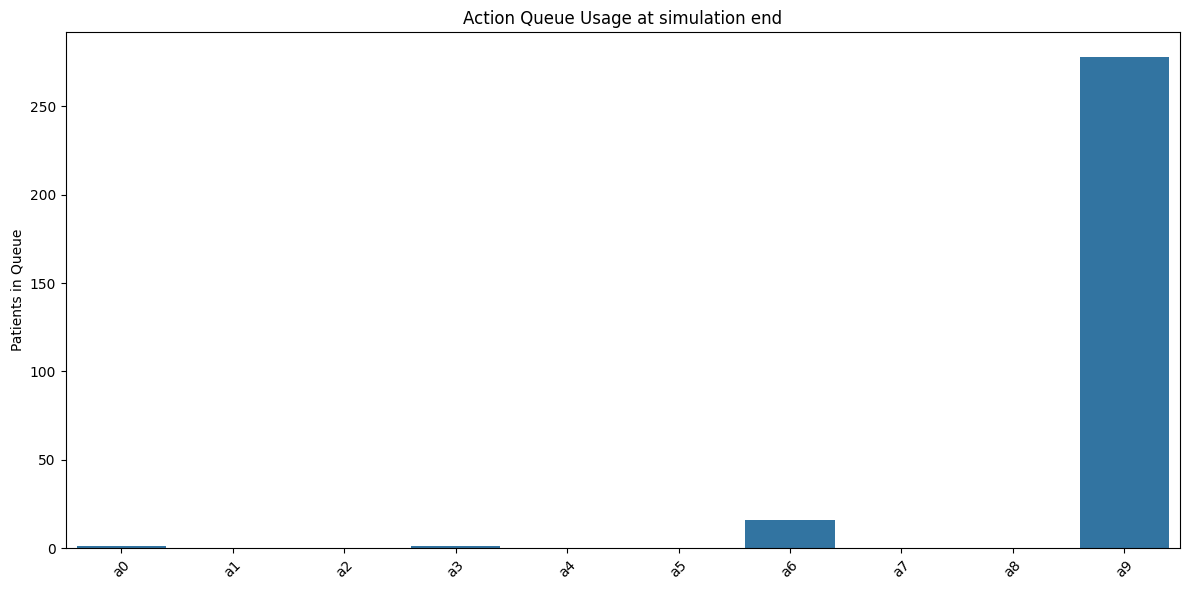

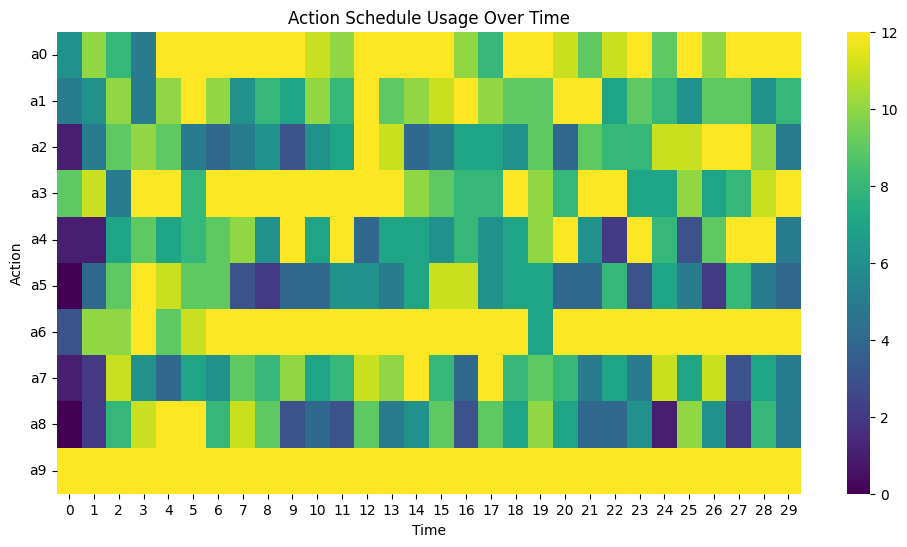

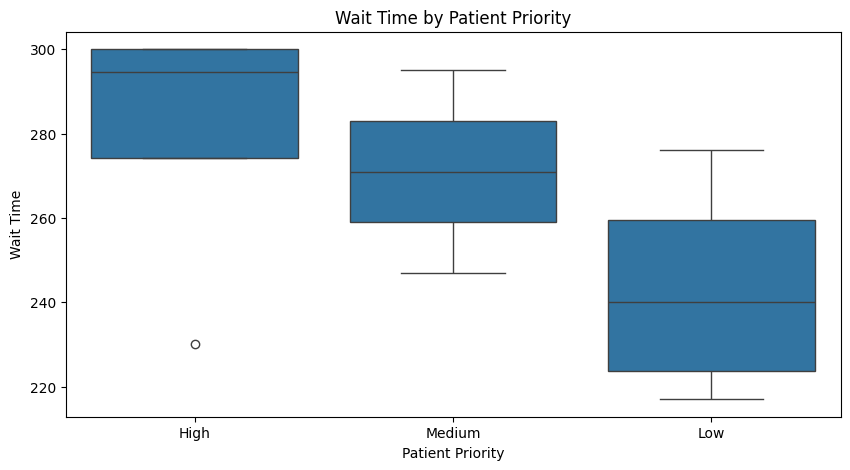

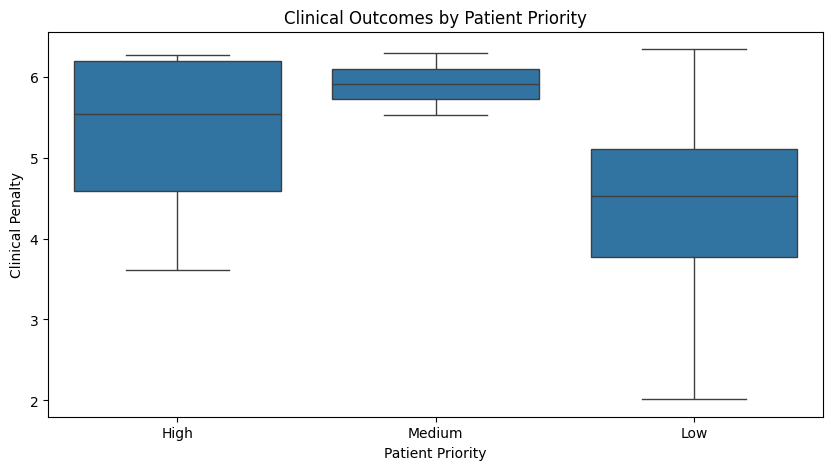

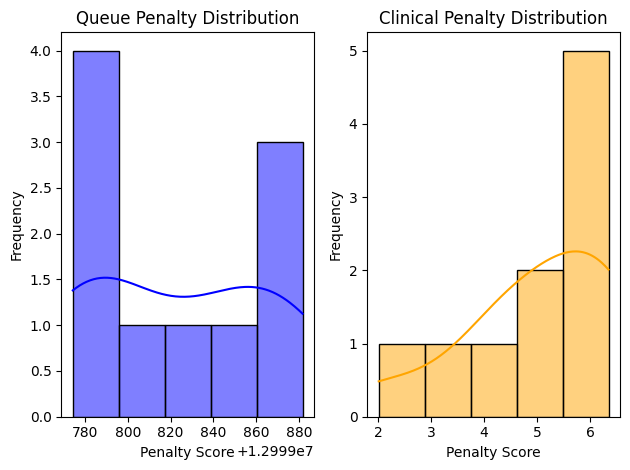

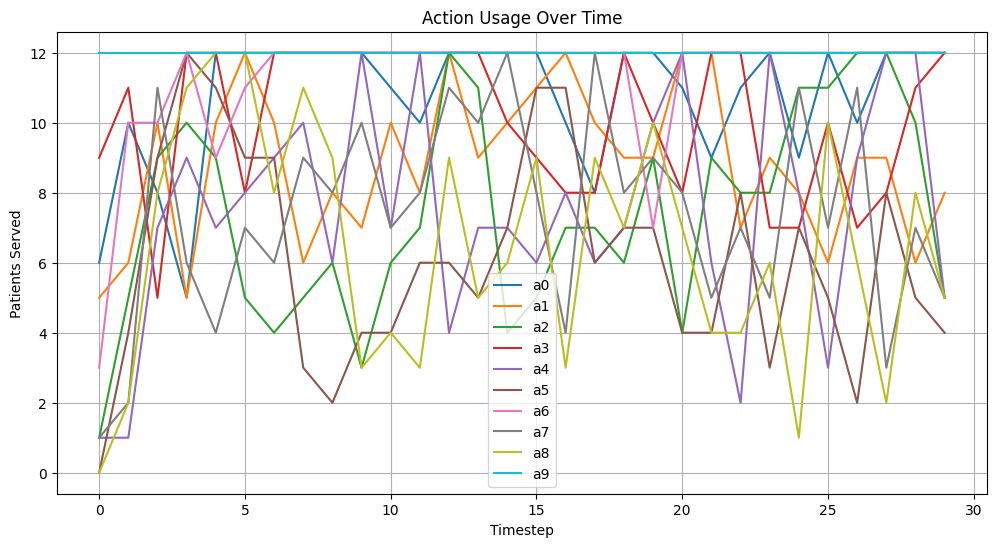

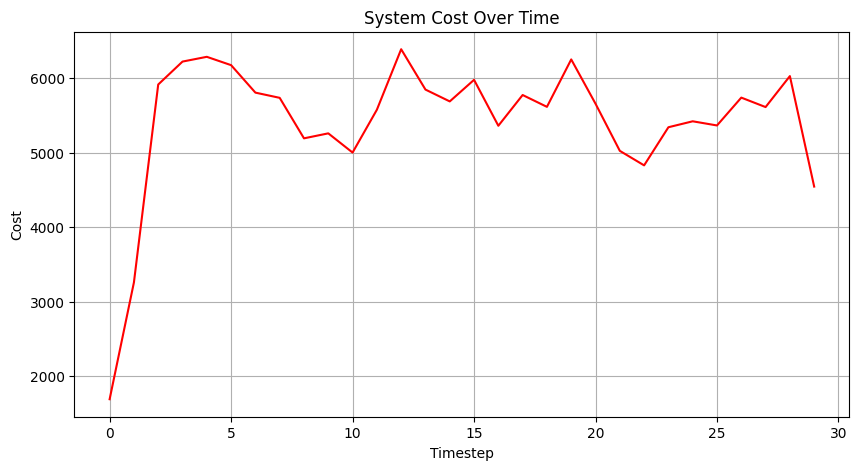

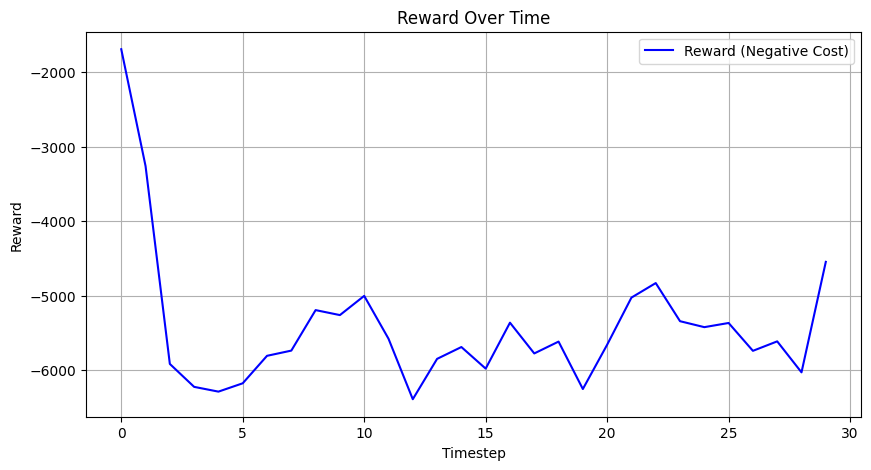

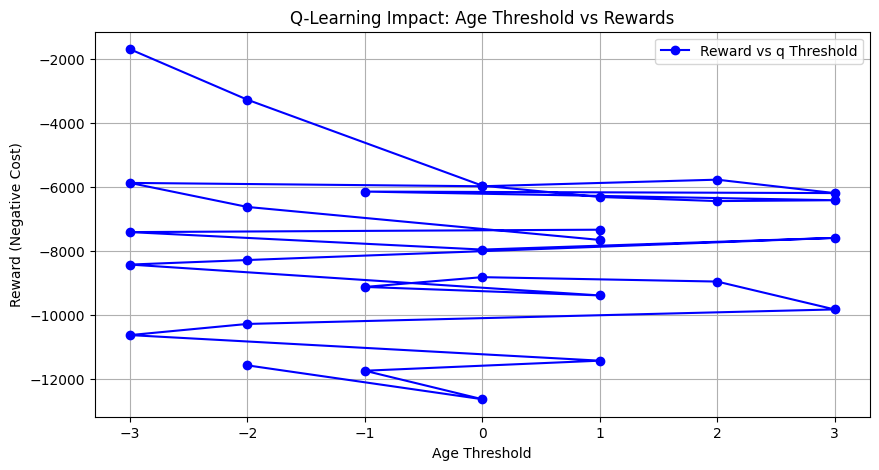

Total system cost: 162639
Average queue penalty: 12999823.513500001
Average clinical penalty: 5.02067685009631
Average wait time: 263.4
Average clinical variables: {'bp': 120.57297912163298, 'glucose': 90.16071481735375, 'bmi': 21.510376973680714, 'oxygen': 98.81687720112521, 'mental_health': 80.52718963506979}
Optimised Q-values for state-action pairs:
Best Q-learning action per pathway (state):
  Pathway: d0 | Best q_threshold: -1 | Q-value: -110247.82
  Pathway: d1 | Best q_threshold: -1 | Q-value: -110187.83
  Pathway: d2 | Best q_threshold: 3 | Q-value: -109748.63
  Pathway: d3 | Best q_threshold: 1 | Q-value: -110054.68
  Pathway: d4 | Best q_threshold: -3 | Q-value: -110278.64
  Pathway: d5 | Best q_threshold: -1 | Q-value: -110034.16
  Pathway: d6 | Best q_threshold: 3 | Q-value: -110502.35
  Pathway: d7 | Best q_threshold: -3 | Q-value: -110568.08
  Pathway: d8 | Best q_threshold: 3 | Q-value: -110715.39
  Pathway: d9 | Best q_threshold: 3 | Q-value: -110007.60


In [69]:
# Step 7: Visualizations
"""
This cell provides various visualizations to analyze the simulation results:

1. **Action Queue Usage**:
    - A bar plot showing the number of patients in the queue for each action at the end of the simulation.

2. **Action Schedule Usage Over Time**:
    - A heatmap displaying the number of patients served by each action over time.

3. **Wait Time by Patient Priority**:
    - A boxplot illustrating the distribution of wait times for patients based on their priority levels.

4. **Penalty Distributions**:
    - Histograms showing the distribution of queue penalties and clinical penalties across all patients.

5. **Action Usage Over Time**:
    - A line plot showing the number of patients served by each action at each timestep.

6. **System Cost Over Time**:
    - A line plot showing the total system cost at each timestep.

7. **Reward Over Time**:
    - A line plot showing the reward (negative cost) over time, reflecting the system's performance.

8. **Q-values for State-Action Pairs**:
    - A line plot showing the Q-values for each state-action pair, providing insights into the learning process.

9. **Age Threshold vs Rewards**:
    - A line plot showing the relationship between dynamically adjusted age thresholds and the corresponding rewards (negative costs).
"""

plt.figure(figsize=(12, 6))
plt.title("Action Queue Usage at simulation end")
sns.barplot(x=list(actions.keys()), y=[len(act.queue) for act in actions.values()])
plt.ylabel("Patients in Queue")
#sns.barplot(x=list(schedule.keys()), y=[len(v) for v in schedule.values()])
#plt.ylabel("Patients Served")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

heatmap_data = np.array([act.schedule for act in actions.values()])

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="viridis", annot=False, cbar=True)
plt.title("Action Schedule Usage Over Time")
plt.xlabel("Time")
plt.ylabel("Action")
plt.yticks(ticks=np.arange(len(actions)) + 0.5, labels=list(actions.keys()), rotation=0)
plt.show()

# Create a DataFrame for patient data for the boxplot
patient_data = {
    "Priority": [patient.priority for patient in patients],
    "Wait Time": [patient.queue_time for patient in patients]
}
patient_df = pd.DataFrame(patient_data)

# Create the boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=patient_df, x="Priority", y="Wait Time")
plt.title("Wait Time by Patient Priority")
plt.xlabel("Patient Priority")
plt.ylabel("Wait Time")
plt.show()

# Prepare data for clinical outcomes boxplot
clinical_outcomes_data = {
    "Priority": [patient.priority for patient in patients],
    "Clinical Penalty": [patient.outcomes['clinical_penalty'] for patient in patients]
}
clinical_outcomes_df = pd.DataFrame(clinical_outcomes_data)

# Create the boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(data=clinical_outcomes_df, x="Priority", y="Clinical Penalty")
plt.title("Clinical Outcomes by Patient Priority")
plt.xlabel("Patient Priority")
plt.ylabel("Clinical Penalty")
plt.show()

# Subplot 1: Queue Penalty
plt.subplot(1, 2, 1)
sns.histplot([p.outcomes['queue_penalty'] for p in patients], kde=True, color='blue')
plt.title("Queue Penalty Distribution")
plt.xlabel("Penalty Score")
plt.ylabel("Frequency")

# Subplot 2: Clinical Penalty
plt.subplot(1, 2, 2)
sns.histplot([p.outcomes['clinical_penalty'] for p in patients], kde=True, color='orange')
plt.title("Clinical Penalty Distribution")
plt.xlabel("Penalty Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Queue usage
plt.figure(figsize=(12,6))
for name, act in actions.items():
    plt.plot(act.schedule, label=name)
plt.title("Action Usage Over Time")
plt.xlabel("Timestep")
plt.ylabel("Patients Served")
plt.legend()
plt.grid(True)
plt.show()

# System cost over time
plt.figure(figsize=(10,5))
plt.plot(system_cost, color='red')
plt.title("System Cost Over Time")
plt.xlabel("Timestep")
plt.ylabel("Cost")
plt.grid(True)
plt.show()

# Visualize the reward over time
plt.figure(figsize=(10, 5))
plt.plot([-cost for cost in system_cost], label="Reward (Negative Cost)", color="blue")
plt.title("Reward Over Time")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.show()

# Extract age_thresholds and rewards from age_threshold_rewards
q_thresholds, rewards = zip(*q_threshold_rewards)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(q_thresholds, rewards, marker='o', linestyle='-', color='blue', label='Reward vs q Threshold')
plt.title("Q-Learning Impact: Age Threshold vs Rewards")
plt.xlabel("Age Threshold")
plt.ylabel("Reward (Negative Cost)")
plt.grid(True)
plt.legend()
plt.show()

print("Total system cost:", sum(system_cost))
print("Average queue penalty:", np.mean([p.outcomes['queue_penalty'] for p in patients]))
print("Average clinical penalty:", np.mean([p.outcomes['clinical_penalty'] for p in patients]))
print("Average wait time:", np.mean([p.queue_time for p in patients]))
print("Average clinical variables:", {k: np.mean([p.clinical[k] for p in patients]) for k in IDEAL_CLINICAL_VALUES.keys()})
print("Optimised Q-values for state-action pairs:")

# Summarize what Q-learning has learnt: best action per pathway (state)
best_actions = {}
for state, actions_dict in q_table.items():
    if actions_dict:
        best_action = max(actions_dict, key=lambda a: actions_dict[a])
        best_q = actions_dict[best_action]
        best_actions[state] = (best_action, best_q)

print("Best Q-learning action per pathway (state):")
for state, (action, q_value) in best_actions.items():
    print(f"  Pathway: {state} | Best q_threshold: {action} | Q-value: {q_value:.2f}")

In [71]:
# Display activity_log as a DataFrame (tabular form)
activity_df = pd.DataFrame(activity_log)
display(activity_df.head(20))  # Show first 20 rows for brevity

# filter to one example patient for clarity
example_patient_df = activity_df[activity_df['patient_id'] == 3]
#example_patient_df = activity_df

# Prepare data for Sankey diagram
filtered_df = example_patient_df.dropna(subset=['previous_action', 'action_name'])
sources = filtered_df['previous_action']
targets = filtered_df['action_name']
labels = list(pd.unique(pd.concat([sources, targets])))
label_indices = {label: idx for idx, label in enumerate(labels)}
source_indices = sources.map(label_indices)
target_indices = targets.map(label_indices)
values = [1] * len(filtered_df)  # Each transition counts as 1

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
    ))])

fig.update_layout(title_text="Patient Action Flow (Sankey Diagram)", font_size=10)
fig.show()

,action_name,patient_id,simulation_time,previous_action,next_action
0,a0,0,0,None,a9
1,a6,0,0,a0,a9
2,a3,0,0,a6,a9
3,a9,0,0,a3,None
4,a9,0,0,a9,None
5,a9,0,0,a9,None
6,a9,0,0,a9,None
7,a9,0,0,a9,None
8,a9,0,0,a9,None
9,a9,0,0,a9,None
